## Drone live face recognition.

In [31]:
import pandas as pd
import numpy as np
import os
import warnings
import cv2
from sklearn.model_selection import train_test_split
# Note, using tf model instead of sklearn model
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

warnings.filterwarnings("ignore")
faces_ = pd.read_csv("./faces.csv")

print("TensorFlow version:", tf.__version__)
print("Numpy version:", np.__version__)
print("Physical devices:", tf.config.list_physical_devices())
print("GPU devices:", tf.config.list_physical_devices('GPU'))
print("NumPy version:", np.__version__)
print("Matplotlib version:", plt.matplotlib.__version__)

TensorFlow version: 2.16.2
Numpy version: 1.26.4
Physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
NumPy version: 1.26.4
Matplotlib version: 3.9.2


In [32]:
faces_.head()


,image_name,width,height,x0,y0,x1,y1
0,00001722.jpg,1333,2000,490,320,687,664
1,00001044.jpg,2000,1333,791,119,1200,436
2,00001050.jpg,667,1000,304,155,407,331
3,00001736.jpg,626,417,147,14,519,303
4,00003121.jpg,626,418,462,60,599,166


In [33]:
faces_.columns

Index(['image_name', 'width', 'height', 'x0', 'y0', 'x1', 'y1'], dtype='object')

In [34]:
is_dup = faces_["image_name"].value_counts()
print(is_dup)
duplicated_values = is_dup[is_dup > 1].index.tolist()
print(f"\nValues that are duplicated: {len(duplicated_values)}")

image_name
00000657.jpg    12
00003172.jpg    11
00003165.jpg    11
00000508.jpg    10
00000737.jpg     9
                ..
00003430.jpg     1
00003418.jpg     1
00001569.jpg     1
00002074.jpg     1
00000103.jpg     1
Name: count, Length: 2204, dtype: int64

Values that are duplicated: 491


## Create a map of image paths with width, height, x0, y0, x1, y1
Above showed about 400 duplicate values

In [35]:
data = {}
for i in faces_['image_name']:
    if i not in data:
        data[i] = []

for index, image_name in enumerate(faces_["image_name"]):
    width = faces_["width"][index]
    height = faces_["height"][index]
    x0 = faces_["x0"][index]
    x1 = faces_["x1"][index]
    y0 = faces_["y0"][index]
    y1 = faces_["y1"][index]
    new_x0 = int((x0/width)*224)
    new_x1 = int((x1/width)*224)
    new_y0 = int((y0/width)*224)
    new_y1 = int((y1/width)*224)
    data[image_name].append(new_x0)
    data[image_name].append(new_x1)
    data[image_name].append(new_y0)
    data[image_name].append(new_y1)


print(data)
print(len(data))

{'00001722.jpg': [82, 115, 53, 111], '00001044.jpg': [88, 134, 13, 48], '00001050.jpg': [102, 136, 52, 111], '00001736.jpg': [52, 185, 5, 108], '00003121.jpg': [165, 214, 21, 59, 113, 157, 56, 90, 12, 57, 25, 60, 90, 134, 33, 66, 59, 109, 42, 80], '00000400.jpg': [55, 140, 22, 90], '00002571.jpg': [27, 73, 37, 77, 139, 180, 47, 82], '00000366.jpg': [42, 125, 21, 87, 75, 159, 0, 35], '00002565.jpg': [42, 170, 7, 90], '00001939.jpg': [71, 140, 20, 76], '00001087.jpg': [88, 134, 5, 41], '00001093.jpg': [79, 106, 7, 57], '00001905.jpg': [50, 144, 7, 81], '00001911.jpg': [89, 125, 52, 76, 109, 161, 31, 66, 65, 116, 11, 46], '00002997.jpg': [68, 92, 62, 80, 94, 122, 5, 27, 144, 173, 28, 51], '00003451.jpg': [82, 124, 43, 114], '00001246.jpg': [78, 134, 11, 58], '00001520.jpg': [139, 201, 51, 99, 6, 70, 39, 88, 76, 138, 56, 103, 99, 162, 48, 96, 186, 223, 43, 90], '00002029.jpg': [96, 134, 42, 108], '00003337.jpg': [77, 112, 3, 44, 78, 111, 98, 136, 10, 36, 133, 163], '00003323.jpg': [93, 135

In [36]:
img_dir = os.listdir('./images')
images = []
for img_name in data.keys():
    for itr in img_dir:
        if img_name == itr:
            img_arr = cv2.imread(os.path.join('./images', img_name), cv2.IMREAD_GRAYSCALE)
            img_resize = cv2.resize(img_arr, (224, 224))
            images.append(img_resize)

In [37]:
images = np.array(images)
print(images.shape)

images = np.expand_dims(images, axis=3)
print(images.shape)

(2204, 224, 224)
(2204, 224, 224, 1)


## Show some images

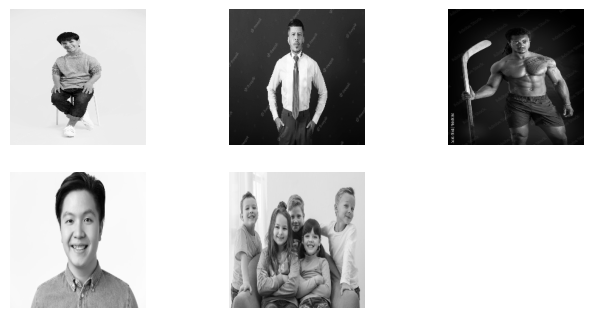

In [38]:
plt.figure(figsize=(8,6))
for i in range(5):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i], cmap='gray')
    plt.axis('off')

## Create bbox or bounding box for object detection
Creating the bbox by first appending all arrays of N lengths to bbox
Find the maximum number of faces possible for any image i.e 12
Initilize a np array of zeros with a shape(images_len, max_bbox, COCO)
Normalize y_labels

In [39]:
# Create a bbox array in order with data Dataframe
bbox = []
for i in data.keys():
    bbox.append(data[i])

# Find the maximum number of faces AKA bbox for each image
# Since arrays can vary from [.,.,.,., * 4]
max_bbox = 0
for i in range(len(bbox)):
    max_bbox = max(max_bbox, len(bbox[i]))

y_label = np.zeros((len(data.keys()), int(max_bbox // 4), 5))
for i in range(len(bbox)):
    if int(max_bbox) - len(bbox[i]) != 0:
        reshape_cord = np.array(bbox[i]).reshape(-1,4)
        num_boxes = reshape_cord.shape[0]
        y_label[i, :num_boxes, :4] = reshape_cord
        y_label[i, :num_boxes, 4] = 1.0

y_label = y_label/224.0
images = images/225.0
print(y_label.shape)
print(y_label[0])

(2204, 12, 5)
[[0.36607143 0.51339286 0.23660714 0.49553571 0.00446429]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


In [40]:
X_train, X_test, y_train, y_test = train_test_split(images, y_label, test_size=0.2, random_state=42)

In [47]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Reshape, Flatten


model = Sequential([
    Conv2D(32, 3, input_shape=(224,224,1), padding="same", activation="relu"),
    Dropout(0.1),
    MaxPool2D(pool_size=2),
    BatchNormalization(),
    Conv2D(64, 3, padding="same", activation="relu"),
    Dropout(0.2),
    MaxPool2D(pool_size=2),
    BatchNormalization(),
    Conv2D(128, 3, padding="same", activation="relu"),
    Dropout(0.3),
    MaxPool2D(pool_size=2),
    BatchNormalization(),
    Conv2D(256, 3, padding="same", activation="relu"),
    Dropout(0.4),
    MaxPool2D(pool_size=2),
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(512, activation="relu"),
    Dense((int(max_bbox//4) * 5), activation="sigmoid"),
    Reshape((int(max_bbox//4),5))
])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 60)             │        30,780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 12, 5)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 552,124 (2.11 MB)

 Trainable params: 551,164 (2.10 MB)

 Non-trainable params: 960 (3.75 KB)

In [48]:
""" 
    Custom function for new col in y_label
    
"""
def custom_detection_loss(y_true, y_pred):
    # y_true/y_pred shape: (Batch, 12, 5)
    
    # 1. Separate Coordinates and Confidence
    true_boxes = y_true[..., :4]  # (Batch, 12, 4)
    true_conf = y_true[..., 4]    # (Batch, 12)
    
    pred_boxes = y_pred[..., :4]  # (Batch, 12, 4)
    pred_conf = y_pred[..., 4]    # (Batch, 12)
    
    # 2. Confidence Loss (Objectness)
    # We use 'binary_crossentropy' but must ensure it doesn't reduce the 12 dimension yet
    conf_loss = tf.keras.metrics.binary_crossentropy(true_conf, pred_conf) # Result: (Batch,)
    
    # 3. Coordinate Loss (Localization)
    # Calculate MSE per box: (Batch, 12)
    coord_diff = tf.reduce_sum(tf.square(true_boxes - pred_boxes), axis=-1)
    
    # Only count loss for boxes that actually exist (where true_conf is 1)
    masked_coord_loss = coord_diff * true_conf
    
    # Sum the coordinate losses for all 12 slots and average by batch
    total_coord_loss = tf.reduce_mean(tf.reduce_sum(masked_coord_loss, axis=-1))
    
    # Return the combined mean loss
    return tf.reduce_mean(conf_loss) + (total_coord_loss * 5.0)

In [ ]:
model.compile(loss=custom_detection_loss, optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
his = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50)


Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 221ms/step - accuracy: 0.2452 - loss: 0.4627 - val_accuracy: 0.3022 - val_loss: 0.1432
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 199ms/step - accuracy: 0.3005 - loss: 0.0826 - val_accuracy: 0.2623 - val_loss: 0.0404
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 199ms/step - accuracy: 0.3013 - loss: 0.0332 - val_accuracy: 0.0763 - val_loss: 0.0315
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 213ms/step - accuracy: 0.3281 - loss: 0.0242 - val_accuracy: 0.1712 - val_loss: 0.0297
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 218ms/step - accuracy: 0.3644 - loss: 0.0215 - val_accuracy: 0.1895 - val_loss: 0.0225
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 209ms/step - accuracy: 0.3460 - loss: 0.0189 - val_accuracy: 0.2039 - val_loss: 0.0211
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 209ms/step - accuracy: 0.3587 - loss: 0.0193 - val_accuracy: 0.2929 - val_loss: 0.0199
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 227ms/step - accuracy: 0.3580 - loss: 0.0176 - val_accu